In [4]:
import importlib
import modules

importlib.reload(modules)

from modules import CA
import matplotlib.pyplot as plt


Transient length: no transient found


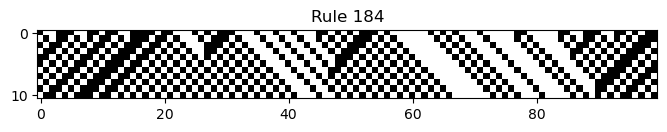

In [5]:
ca_184 = CA()

p = 0.5
L = 100
initial_state = ca_184.gen_initial_state_bernoulli(L, p)
lambda_parameter, evolution = ca_184.gen_CA(L, r=1, k=2, dec_rule=184, t_end=10, s_q='0')
transient_length = ca_184.calculate_transient_length()

plt.figure(figsize=(8,10))
plt.title(f'Rule 184')
plt.imshow(evolution, cmap='binary')

print(f"Transient length: {transient_length}")


In [6]:
import cellpylib as cpl
import numpy as np

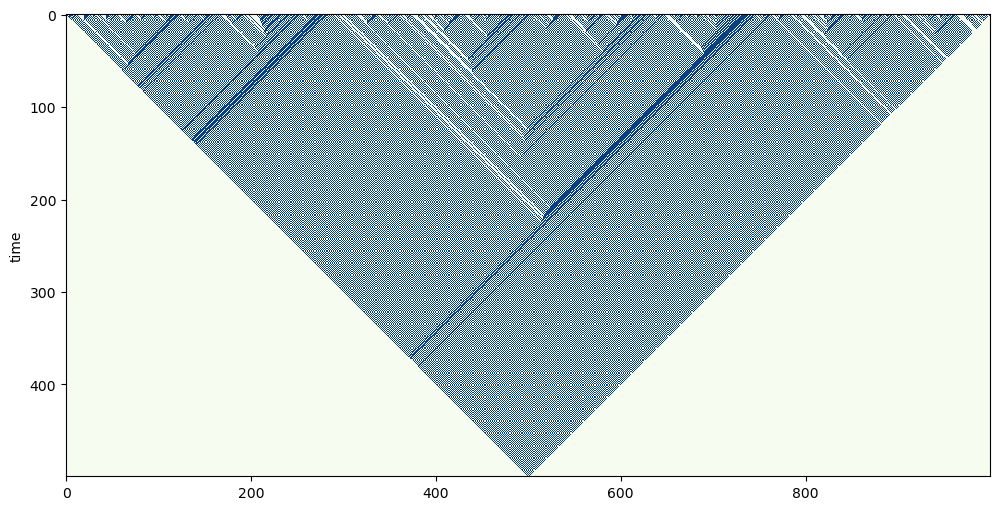

In [7]:
importlib.reload(modules)
from modules import triangulize_evolution

p = 0.5
L = 1000
T = int(L / 2)
initial_state = ca_184.gen_initial_state_bernoulli(L, p)

# print(cellular_automaton)
cellular_automaton = cpl.evolve(initial_state, timesteps=T, memoize=True, apply_rule=lambda n, c, t: cpl.nks_rule(n, rule=184))
cellular_automaton = triangulize_evolution(cellular_automaton)

fig, ax = plt.subplots(figsize=(12, 6))  # Adjust the size as needed
cpl.plot(cellular_automaton, colormap='GnBu')



In [8]:
importlib.reload(modules)
from modules import find_elem_jams

jams = find_elem_jams(cellular_automaton)
print(f"The jams in the evolution above are: {jams}")
print(f"\'[[i, j], size]\' with i and j being the row coordinates in the row that the jam was last found in and size being the size of the jam.")
jam_sizes = [jam[1] for jam in jams]
print(f"Jam sizes: {jam_sizes}")

The jams in the evolution above are: [[[1, 2], 2], [[2, 4], 9], [[5, 6], 12], [[20, 21], 20], [[29, 30], 4], [[43, 44], 14], [[46, 47], 16], [[60, 61], 2], [[61, 62], 8], [[61, 62], 19], [[61, 62], 41], [[61, 62], 51], [[61, 62], 67], [[61, 62], 88], [[61, 62], 111], [[61, 62], 140], [[61, 62], 229], [[77, 79], 162], [[77, 79], 184], [[77, 79], 212], [[77, 79], 240], [[79, 80], 160], [[83, 84], 167], [[125, 127], 151], [[125, 127], 166], [[125, 127], 188], [[125, 127], 251], [[125, 127], 272], [[125, 127], 267], [[125, 127], 286], [[125, 127], 328], [[125, 127], 334], [[125, 127], 320], [[125, 127], 326], [[125, 127], 378], [[136, 137], 492], [[136, 137], 500], [[136, 137], 520], [[136, 137], 553], [[138, 140], 555], [[140, 142], 423], [[304, 305], 2], [[326, 327], 40], [[345, 346], 2], [[349, 350], 6], [[349, 350], 14], [[349, 350], 20], [[369, 370], 8], [[370, 371], 26], [[370, 371], 67], [[370, 371], 83], [[370, 371], 112], [[370, 371], 142], [[370, 371], 140], [[370, 371], 162], [[

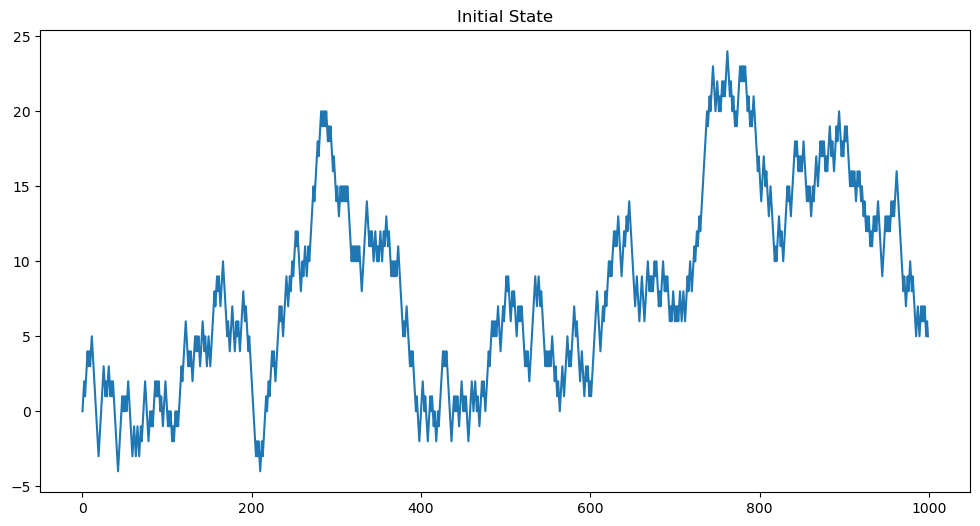

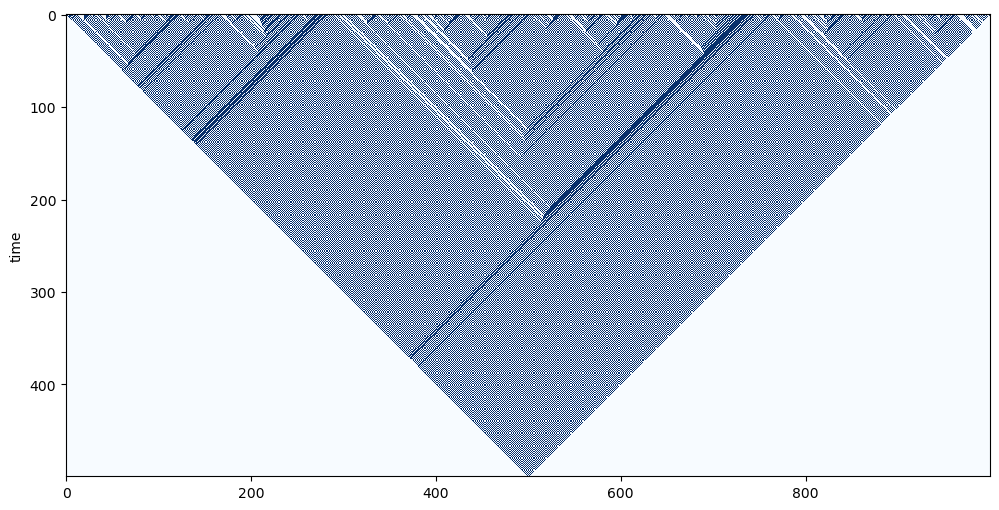

In [9]:
importlib.reload(modules)
from modules import triangulize_evolution
from modules import initial_to_random_walk

# Plot the random walk that is the initial state, go up for 1, down for 0
random_walk = initial_to_random_walk(initial_state)

plt.figure(figsize=(12,6))
plt.title(f'Initial State')
plt.plot(random_walk)

cellular_automaton = triangulize_evolution(cellular_automaton)

fig, ax = plt.subplots(figsize=(12, 6))  # Adjust the size as needed
cpl.plot(cellular_automaton, colormap='Blues')





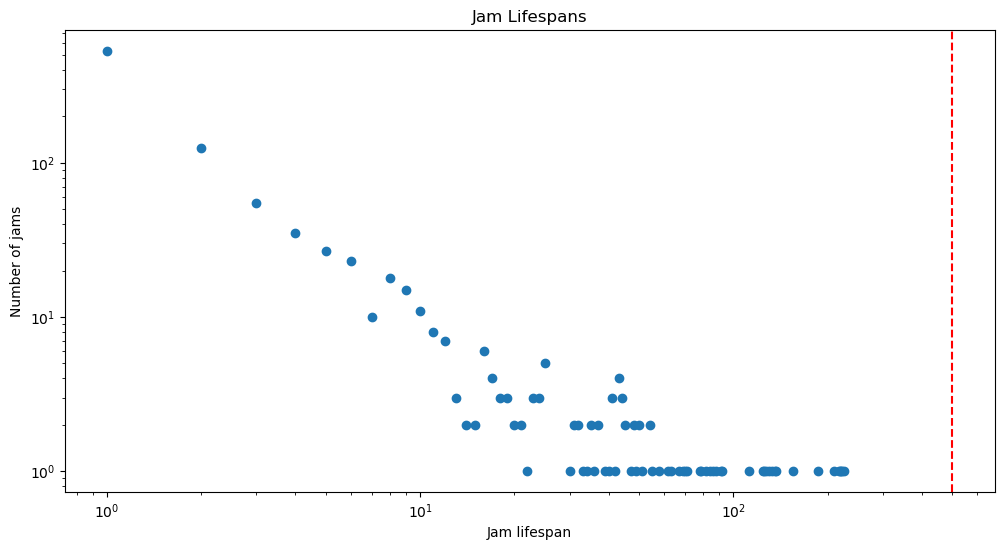

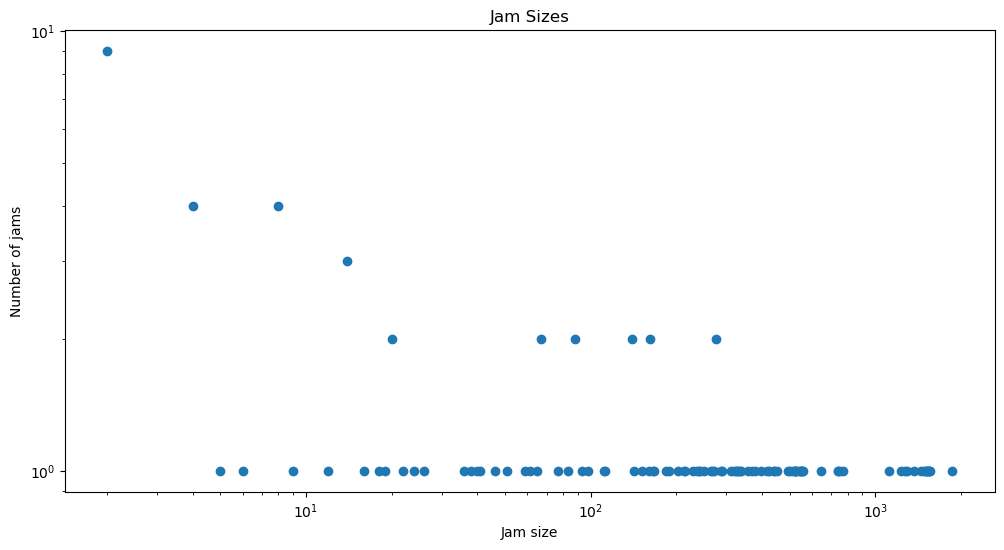

Number of jam lifespan values: 78
Number of elementary jam size values: 104


In [10]:
from collections import Counter
importlib.reload(modules)
from modules import jam_lifespans

lifespans = jam_lifespans(random_walk)

# Count the number of jams of each duration
jam_lifespans = Counter(lifespans)

# Plot the distribution of jam lifespans on log log scale
plt.figure(figsize=(12,6))
plt.title(f'Jam Lifespans')
plt.loglog(jam_lifespans.keys(), jam_lifespans.values(), 'o')
plt.xlabel('Jam lifespan')
plt.ylabel('Number of jams')

# Add a vertical line at T
plt.axvline(x=T, color='red', linestyle='--')
plt.show()

# Count and plot the jam sizes:
jam_sizes = Counter(jam_sizes)

plt.figure(figsize=(12,6))
plt.title(f'Jam Sizes')
plt.loglog(jam_sizes.keys(), jam_sizes.values(), 'o')
plt.xlabel('Jam size')
plt.ylabel('Number of jams')
plt.show()

print(f"Number of jam lifespan values: {len(jam_lifespans.keys())}")
print(f"Number of elementary jam size values: {len(jam_sizes.keys())}")

